In [1]:
from scipy.stats import norm
import numpy as np

Пример 1. Имеется 0,1 млн рублей, которые клиент готов инвестировать на 1 год. Текущая цена акции 100 руб., прогнозируется рост акции. Волатильность акции – 30%, депозитная процентная ставка и безрисковая процентная ставка – 7%. Периодичность наблюдения – 1 день. Постройте структурный продукт с полной гарантией возврата инвестированного капитала и азиатского опциона call и вычислите коэффициент участия.

In [16]:
def Geometric_Average_Rate_Call(S , K , T , r , b , sigma):
    sigmaA = sigma/np.sqrt(3)
    bA = (b - sigma**2/6)/2
    d1 = (np.log(S/K)+(bA + sigmaA**2/2)*T)/(sigmaA*np.sqrt(T))
    d2 = d1 - sigmaA * np.sqrt(T)
    return S * np.exp((bA - r)*T) * norm.cdf(d1) - K * np.exp(-r*T)*norm.cdf(d2)

S = 100
K = 100
T = 1
r = 0.07
q = 0.0
sigma = 0.3

print ('Geometric average rate call =', Geometric_Average_Rate_Call(S , K , T , r , r-q , sigma))
# 7.906075677449117

# Вычислите коэффициент участия
# PR = 85.5%

Geometric average rate call = 7.906075677449117


Пример 2. Оцените стоимость азиатского опциона колл с использованием метода Монте-Карло. При условиях цена базового актива и страйк 100, дата экспирации через 1 год, безрисковая ставка 7%, волатильность 30%. Переодичность наблюдений - 1 день, количество траекторий 1000.

In [17]:
# Box-Muller transform to generate normal deviates
def getGaussian(mu, sigma, n):

    # Generate a pair of uniform random variables U,V
    U = np.random.uniform(0, 1, n)
    V = np.random.uniform(0, 1, n)

    # Get R~Exponential(1) and Theta~Uniform(0, 2pi) random variables
    R     = -np.log(U)
    Theta = 2*np.pi*V

    # Transform to X and Y
    X = np.multiply(np.sqrt(2*R), np.cos(Theta))
    Y = np.multiply(np.sqrt(2*R), np.sin(Theta))

    # Perform location-scale transform
    X = mu + sigma*X
    Y = mu + sigma*Y
    return X, Y

In [134]:
def gbm_mcs(mu, sigma, S0, T, n, noOfPaths):
    S = []
    delta_t = T/n
    # Mean and variance of a lognormal random walk
    mean = S0 * np.exp((mu+(0.5*sigma**2))*T)
    variance = (S0 ** 2)*np.exp(2*mu*T + 2*(sigma ** 2)*T)*(np.exp(sigma**2)*T-1)
    for i in range(noOfPaths):
        X, Y = getGaussian(0, 1, n)
        dz_t = X
        dW_t = np.sqrt(delta_t) * dz_t
        dX_t = mu * delta_t + sigma * dW_t
        X_t = np.cumsum(dX_t)
        S_t = S0 * np.exp(X_t)
        S.append(S_t)
    S = np.array(S)
    return S, mean, variance

In [135]:
S0    = 100

noOfPaths = 10_000
T = 1
n = 250

K = 100
r = 0.07

sigma = 0.3
mu = r - (0.5*sigma**2)

In [136]:
# Simulate a lognormal random walk
S, mean, variance = gbm_mcs(mu, sigma, S0, T, n, noOfPaths)
c = 0.0
for i in range(noOfPaths):
    c = c + max(np.mean(S[i]) - K, 0)
disc = np.exp(-r*T)
c = disc * (c/noOfPaths)
print(c)

8.385695434524816


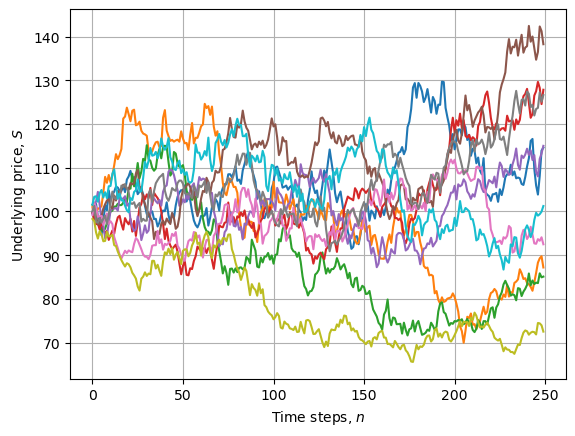

In [137]:
import matplotlib.pyplot as plt

time = list(range(n))
for i in range(10):
    plt.plot(time, S[i])

plt.xlabel('Time steps, $n$')
plt.ylabel('Underlying price, $S$')
plt.grid(True)
plt.show()

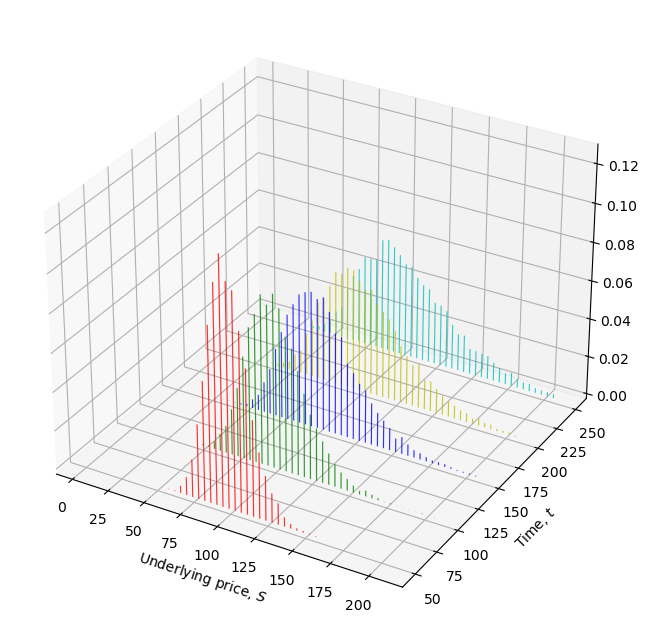

In [138]:
from mpl_toolkits.mplot3d import Axes3D
#from matplotlib import cm

sd = np.sqrt(variance)
step = 50

# Density plot of the underlying price
fig = plt.figure(figsize=(10,8))
ax  = fig.add_subplot(111,projection='3d')
x   = np.linspace(mean-3*sd, mean+3*sd, step+1)

#time = list(range(n))

for i,c in zip([50,100,150,200,250],['r','g','b','y','c']): # использовать переменную step и избавиться от использования констант
    hist, bins = np.histogram(S[:,i-1],bins = x)
    hist = hist/noOfPaths
    cs = [c] * 50
    ax.bar(x[:-1],hist, i, zdir = 'y', color=cs,alpha=0.8)

ax.set_xlabel('Underlying price, $S$')
ax.set_ylabel('Time, $t$')
# подписать ось Oz
plt.show()

В условиях примера 1

1. Вычислите  результаты от инвестирования используя
формулу выплаты:
$$
r_{SP} =
\max\left( r_{SP \min}, r_{SP \min} + PR \times \frac{P_{avg} - S}{S}\right),
$$
здесь $\frac{P_{avg} - S}{S}$ -- доходность базового актива относительно среднего значения $P_{avg}$, $S$ -- цена начала участия, или страйк встроенных опционов (в
простейшем случае он равен цене спот базового актива на момент выпуска продукта, т.\,е. $P_0$).

2. Постройте продукт со встроенным азиатским опционом, оцененным методом Монте-Карло. Для уменьшения разброса в качестве control variate использовать геометрическое усреднение. Вычислите доверительный интервал.

3. Сравните полученные результаты с результатами предыдущих задач и подкрепите выводы иллюстративными графиками.

In [139]:
# task 1: calculate rsp = max(rsp_min, rsp_min + PR * (P_avg - S)/S)

S0 = 100
K = 100
T = 1
r = 0.07
q = 0.0
sigma = 0.3
call_price = Geometric_Average_Rate_Call(S0, K , T , r , r-q , sigma)
print ('Geometric average rate call =', call_price)

cash =100_000
risk_part = cash - cash * np.exp(-r * T)
PR = S0 * round(risk_part / call_price) / cash
print('Participation rate = ', PR)

# task calc Rsp
rsp_min = 1 - 1 # full return guarantee (100%) minus 100%
rsp = np.maximum(rsp_min, rsp_min + PR * (S.mean(axis=1).mean() - S0)/S0)
print('Rsp averaged over 1000 samples = {}%'.format(round(rsp*100,2)))

Geometric average rate call = 7.906075677449117
Participation rate =  0.855
Rsp averaged over 1000 samples = 2.99%


In [140]:
# task 2 evaluate asian option price using MC method
import scipy.stats

print('Observations:', S.shape)
# geometric averaging
S_means = np.prod(S**(1/S.shape[1]), axis=1)
payoffs = np.exp(-r * T) * np.maximum(S_means - K, 0)
avg_payoff = np.mean(payoffs)
std_error = np.sqrt(np.sum((payoffs - avg_payoff)**2) / (payoffs.shape[0] - 1))
print('Mean payoff = ', round(avg_payoff,3))
print('Std error = ', round(std_error, 3))
scaler = scipy.stats.t.ppf((1 + 0.95) / 2., payoffs.shape[0] - 1)
print(f'Confidence interval : [{avg_payoff - std_error * scaler:.3f}(0):{avg_payoff + std_error * scaler:.3f}]')

Observations: (10000, 250)
Mean payoff =  7.907
Std error =  11.65
Confidence interval : [-14.929(0):30.744]


In [141]:
# task 3 compare results

print('Analytical Geometric average rate call =', round(call_price), 2)
print('Relative error for MC method = ', round(abs(call_price - avg_payoff) / call_price * 100, 3), '%\n')

# profit compare with vanilla call
def call(S, K, tau, vol, r, q):
    d1 = (np.log (S / K) + (r + vol**2 / 2) * tau) / (vol * np.sqrt(tau))
    d2 = d1 - vol * np.sqrt(tau)
    return S * np.exp(-q * tau) * norm.cdf(d1) - K * np.exp (-r * tau) * norm.cdf(d2)

call_price = call(S0, K , T , sigma , r, q)
print ('Vanilla call option =', round(call_price, 3))

cash =100_000
risk_part = cash - cash * np.exp(-r * T)
PR = S0 * round(risk_part / call_price) / cash
print('Participation rate = ', PR * 100, '%')

# task calc Rsp
rsp_min = 1 - 1 # full return guarantee (100%) minus 100%
rsp = np.maximum(rsp_min, rsp_min + PR * (S[:, -1].mean() - S0)/S0)
print('Rsp averaged over 1000 samples = {}%'.format(round(rsp*100,2)))

Analytical Geometric average rate call = 8 2
Relative error for MC method =  0.016 %

Vanilla call option = 15.211
Participation rate =  44.4 %
Rsp averaged over 1000 samples = 3.28%


Text(0.5, 0, 'Price S_T')

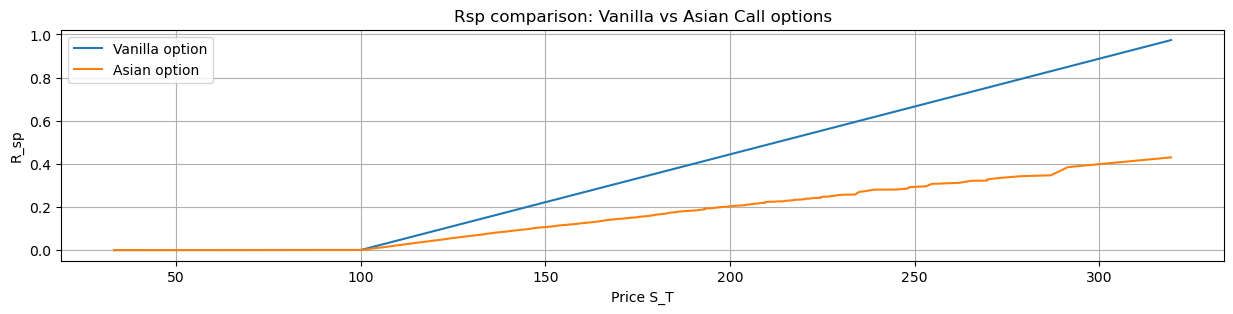

In [162]:
# profit plots
plt.figure(figsize=(15,3))
plt.title('Rsp comparison: Vanilla vs Asian Call options')
rsps = np.maximum(rsp_min, rsp_min + PR * (S[:, -1] - S0)/S0)
plt.plot(sorted(S[:, -1]), sorted(rsps), label='Vanilla option')
rsps2 = np.maximum(rsp_min, rsp_min + PR * payoffs/S0)
plt.plot(sorted(S[:, -1]), sorted(rsps2), label='Asian option')
plt.legend();plt.grid()
plt.ylabel('R_sp')
plt.xlabel('Price S_T')
# according to that payoff for an asian option is dependent on average asset price during the history
# the profit for this product is growth much slower than the one for vanilla option
# but
# it's not necessary has profit starting from price = S0 as below since we plotted only last price 
# not average one, so actually it's possible to have positive pnl starting from price much lower 